In [1]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import numpy as np
import pandas as pd

# Otros objetivos
# -----------------------------------------------------------------------
import math

# Gráficos
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

import os
import sys 
sys.path.append(os.path.abspath("../../src"))   
import soporte_preprocesamiento as f
import warnings
warnings.filterwarnings("ignore")




# Imputación de nulos usando métodos avanzados estadísticos
# -----------------------------------------------------------------------
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor



from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler, RobustScaler


from tqdm import tqdm


# import plotly_express as px


# Métodos estadísticos
# -----------------------------------------------------------------------
from scipy.stats import zscore # para calcular el z-score
from sklearn.neighbors import LocalOutlierFactor # para detectar outliers usando el método LOF
from sklearn.ensemble import IsolationForest # para detectar outliers usando el metodo IF
from sklearn.neighbors import NearestNeighbors # para calcular la epsilon

# Para generar combinaciones de listas
# -----------------------------------------------------------------------
from itertools import product, combinations
pd.set_option("display.max_columns", None)


In [2]:
df_min=pd.read_csv("../../datos/datos4/datos_nulos_encoded_minmax.csv", index_col=0).reset_index(drop=True)


In [3]:
df_min.sample(2)

,price,size_MinMax,rooms_MinMax,municipality_MinMax,distance_MinMax,status_MinMax,floor_MinMax,hasLift_MinMax,propertyType_chalet_MinMax,propertyType_countryHouse_MinMax,propertyType_duplex_MinMax,propertyType_flat_MinMax,propertyType_penthouse_MinMax,propertyType_studio_MinMax,exterior_False_MinMax,exterior_True_MinMax,bathrooms_1_MinMax,bathrooms_2_MinMax,bathrooms_3_MinMax,district_Alcobendas Centro_MinMax,district_Arganzuela_MinMax,district_Barajas_MinMax,district_Barrio de Salamanca_MinMax,district_Buenavista_MinMax,district_Carabanchel_MinMax,district_Carlos Ruiz_MinMax,district_Casco Antiguo_MinMax,district_Casco Histórico_MinMax,district_Casco Urbano_MinMax,district_Centro_MinMax,district_Centro - Casco Histórico_MinMax,district_Centro Urbano_MinMax,district_Chamartín_MinMax,district_Chamberí_MinMax,district_Chorrillo_MinMax,district_Ciudad 70_MinMax,district_Ciudad Lineal_MinMax,district_Dehesa - El Soto_MinMax,district_El Mirador_MinMax,district_El Mirador - Grillero_MinMax,district_El Nido-Las Fuentes_MinMax,district_Ensanche_MinMax,district_Espartales_MinMax,district_Foso-Moreras_MinMax,district_Fuencarral_MinMax,district_Fuentebella-San Felix-El Leguario_MinMax,district_Getafe Centro_MinMax,district_Getafe norte_MinMax,district_Hortaleza_MinMax,district_Hospital_MinMax,district_Juan de Austria_MinMax,district_La Alhóndiga_MinMax,district_La Dehesa - El Pinar_MinMax,district_La Espinilla - Parque Blanco_MinMax,district_Las Américas_MinMax,district_Las Matas- Peñascales_MinMax,district_Las Sedas - El Olivar_MinMax,district_Latina_MinMax,district_Los Llanos - Valle Pardo_MinMax,district_Moncloa_MinMax,district_Montserrat - Parque Empresarial_MinMax,district_Noroeste_MinMax,district_Nuevo Aranjuez-Ciudad de las Artes_MinMax,district_Parla Este_MinMax,district_Parque Europa - Los Pitufos_MinMax,district_Parque Inlasa_MinMax,district_Parque Roma - Coronas_MinMax,district_Parque de la Coruña - Las Suertes_MinMax,district_Pintores-Ferial_MinMax,district_Pol. Industrial sur_MinMax,district_Pryconsa - Poligono Europa_MinMax,district_Puente de Vallecas_MinMax,district_Retiro_MinMax,district_Reyes_MinMax,district_Reyes Católicos_MinMax,district_Rivas Futura_MinMax,district_San Blas_MinMax,district_San Crispín - La Estación Consorcio_MinMax,district_San Isidro_MinMax,district_San Isidro - Los Almendros_MinMax,district_San José - Buenos Aires_MinMax,district_Sudeste Industrial_MinMax,district_Suroeste_MinMax,district_Tetuán_MinMax,district_Universidad_MinMax,district_Usera_MinMax,district_Val_MinMax,district_Valdemorillo pueblo_MinMax,district_Valdepelayo - Montepinos - Arroyo Culebro_MinMax,district_Valderas - Los Castillos_MinMax,district_Valleaguado - La Cañada_MinMax,district_Vega de la Moraleja_MinMax,district_Vicálvaro_MinMax,district_Villa de Vallecas_MinMax,district_Villalba Estación_MinMax,district_Villaverde_MinMax,district_Villayuventus-Renfe_MinMax,district_Zona Estación_MinMax,district_Zona Estación- Centro_MinMax,district_Zona Industrial_MinMax,district_Zona Pueblo_MinMax,district_desconocido_MinMax
147,600.0,0.530973,0.0,1.0,0.123340,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
14,700.0,0.088496,0.0,1.0,0.054314,1.0,0.763434,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Primero identificamos los outliers en univariados

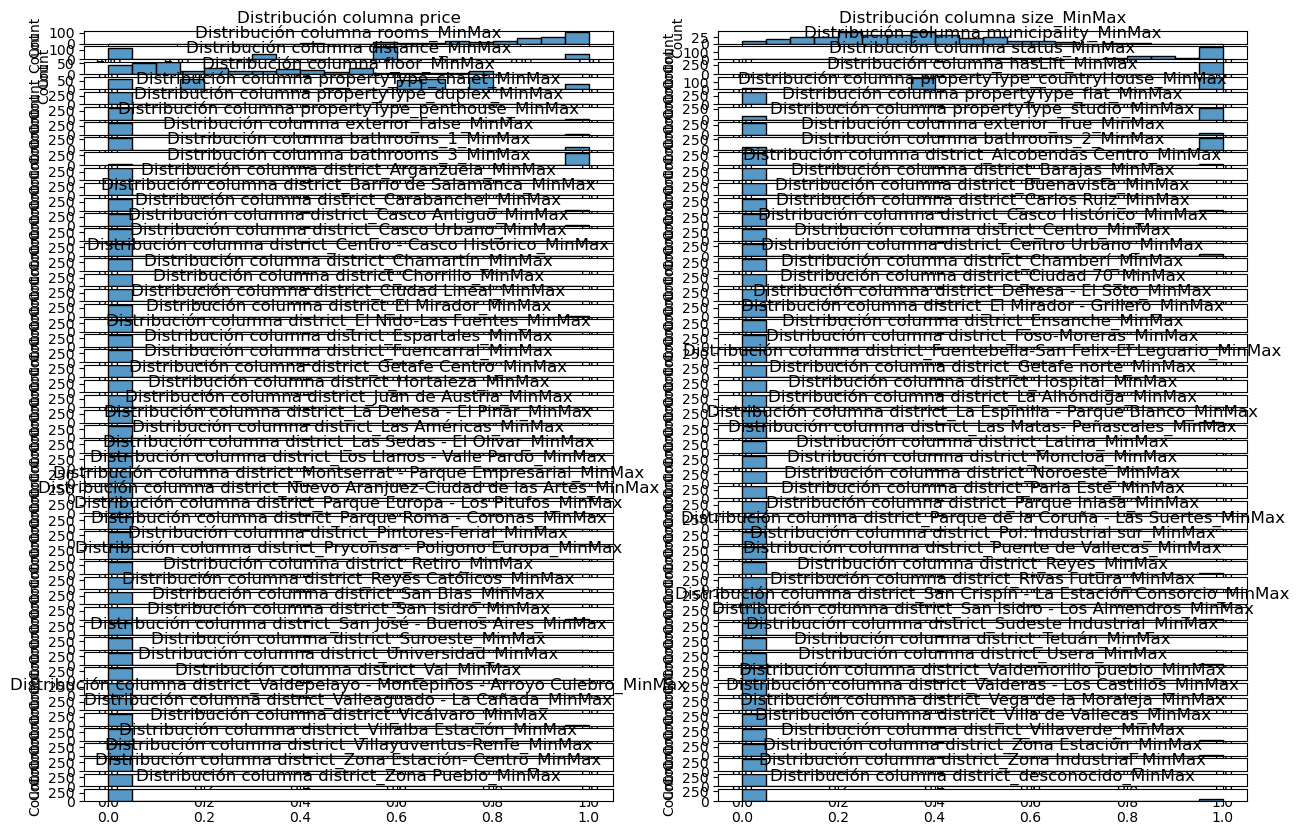

In [4]:
f.plot_outliers_univariados(df_min, "h", (15,10))

Recuerdo la distribución de las numéricas ya seleccionadas mediante la metodología de escalador min max

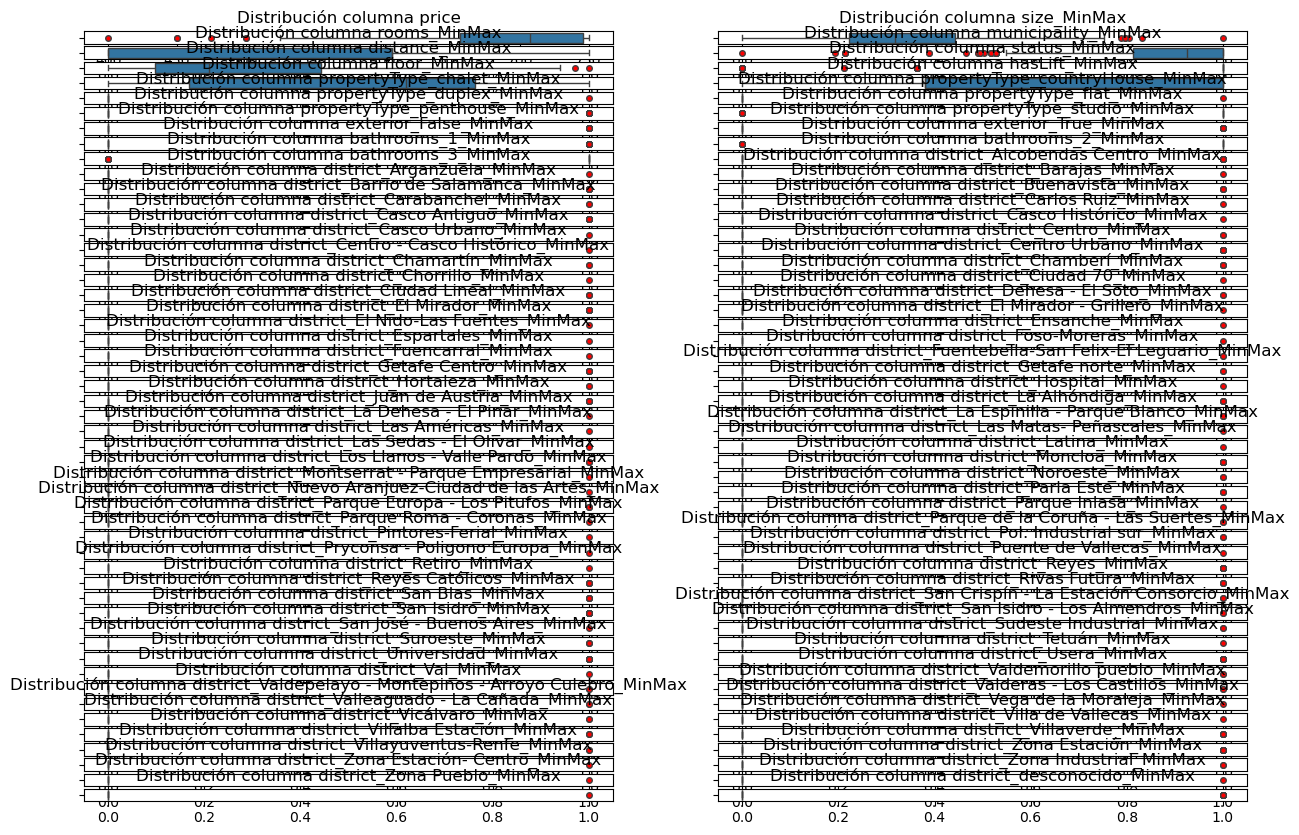

In [5]:
f.plot_outliers_univariados(df_min, "b", (15,10))

Observo los outliers de las numéricas ya seleccionadas mediante la metodología de escalador min max

In [6]:
num=df_min.select_dtypes(include=np.number)
num.describe().T

,count,mean,std,min,25%,50%,75%,max
price,348.0,693.405172,61.418015,400.0,656.000000,707.500000,745.500000,750.0
size_MinMax,348.0,0.337046,0.172292,0.0,0.221239,0.318584,0.442478,1.0
rooms_MinMax,348.0,0.405232,0.348003,0.0,0.000000,0.590423,0.590423,1.0
municipality_MinMax,348.0,0.868116,0.178440,0.0,0.813342,0.924629,1.000000,1.0
distance_MinMax,348.0,0.286565,0.236128,0.0,0.096294,0.208986,0.443174,1.0
...,...,...,...,...,...,...,...,...
district_Zona Estación_MinMax,348.0,0.005747,0.075700,0.0,0.000000,0.000000,0.000000,1.0
district_Zona Estación- Centro_MinMax,348.0,0.002874,0.053606,0.0,0.000000,0.000000,0.000000,1.0
district_Zona Industrial_MinMax,348.0,0.002874,0.053606,0.0,0.000000,0.000000,0.000000,1.0
district_Zona Pueblo_MinMax,348.0,0.002874,0.053606,0.0,0.000000,0.000000,0.000000,1.0


In [7]:
num.columns

Index(['price', 'size_MinMax', 'rooms_MinMax', 'municipality_MinMax',
       'distance_MinMax', 'status_MinMax', 'floor_MinMax', 'hasLift_MinMax',
       'propertyType_chalet_MinMax', 'propertyType_countryHouse_MinMax',
       ...
       'district_Vicálvaro_MinMax', 'district_Villa de Vallecas_MinMax',
       'district_Villalba Estación_MinMax', 'district_Villaverde_MinMax',
       'district_Villayuventus-Renfe_MinMax', 'district_Zona Estación_MinMax',
       'district_Zona Estación- Centro_MinMax',
       'district_Zona Industrial_MinMax', 'district_Zona Pueblo_MinMax',
       'district_desconocido_MinMax'],
      dtype='object', length=102)

In [8]:
dicc_zsc=f.identificar_outliers_zscore(df_min)

La cantidad de outliers para la PRICE es de 6 outliers
La cantidad de outliers para la SIZE_MINMAX es de 1 outliers
La cantidad de outliers para la ROOMS_MINMAX es de 0 outliers
La cantidad de outliers para la MUNICIPALITY_MINMAX es de 6 outliers
La cantidad de outliers para la DISTANCE_MINMAX es de 1 outliers
La cantidad de outliers para la STATUS_MINMAX es de 15 outliers
La cantidad de outliers para la FLOOR_MINMAX es de 0 outliers
La cantidad de outliers para la HASLIFT_MINMAX es de 0 outliers
La cantidad de outliers para la PROPERTYTYPE_CHALET_MINMAX es de 1 outliers
La cantidad de outliers para la PROPERTYTYPE_COUNTRYHOUSE_MINMAX es de 1 outliers
La cantidad de outliers para la PROPERTYTYPE_DUPLEX_MINMAX es de 14 outliers
La cantidad de outliers para la PROPERTYTYPE_FLAT_MINMAX es de 0 outliers
La cantidad de outliers para la PROPERTYTYPE_PENTHOUSE_MINMAX es de 10 outliers
La cantidad de outliers para la PROPERTYTYPE_STUDIO_MINMAX es de 0 outliers
La cantidad de outliers para la E

Dado que no tienen una distribución normal ninguna de ellas, no utilizaré el Z-Score ya que el porcentaje de fallo será demasiado alto. Por ello opto por el IQR

In [9]:
dicc_iqr=f.identificar_outliers_iqr(df_min)

La columna PRICE tiene 6 outliers
La columna SIZE_MINMAX tiene 6 outliers
La columna ROOMS_MINMAX tiene 0 outliers
La columna MUNICIPALITY_MINMAX tiene 26 outliers
La columna DISTANCE_MINMAX tiene 2 outliers
La columna STATUS_MINMAX tiene 28 outliers
La columna FLOOR_MINMAX tiene 0 outliers
La columna HASLIFT_MINMAX tiene 0 outliers
La columna PROPERTYTYPE_CHALET_MINMAX tiene 1 outliers
La columna PROPERTYTYPE_COUNTRYHOUSE_MINMAX tiene 1 outliers
La columna PROPERTYTYPE_DUPLEX_MINMAX tiene 14 outliers
La columna PROPERTYTYPE_FLAT_MINMAX tiene 74 outliers
La columna PROPERTYTYPE_PENTHOUSE_MINMAX tiene 10 outliers
La columna PROPERTYTYPE_STUDIO_MINMAX tiene 48 outliers
La columna EXTERIOR_FALSE_MINMAX tiene 64 outliers
La columna EXTERIOR_TRUE_MINMAX tiene 64 outliers
La columna BATHROOMS_1_MINMAX tiene 35 outliers
La columna BATHROOMS_2_MINMAX tiene 34 outliers
La columna BATHROOMS_3_MINMAX tiene 1 outliers
La columna DISTRICT_ALCOBENDAS CENTRO_MINMAX tiene 1 outliers
La columna DISTRIC

Nos fijamos en que parece haber muy pocos Outliers

In [10]:
dicc_iqr["price"].head(2)

,price,size_MinMax,rooms_MinMax,municipality_MinMax,distance_MinMax,status_MinMax,floor_MinMax,hasLift_MinMax,propertyType_chalet_MinMax,propertyType_countryHouse_MinMax,propertyType_duplex_MinMax,propertyType_flat_MinMax,propertyType_penthouse_MinMax,propertyType_studio_MinMax,exterior_False_MinMax,exterior_True_MinMax,bathrooms_1_MinMax,bathrooms_2_MinMax,bathrooms_3_MinMax,district_Alcobendas Centro_MinMax,district_Arganzuela_MinMax,district_Barajas_MinMax,district_Barrio de Salamanca_MinMax,district_Buenavista_MinMax,district_Carabanchel_MinMax,district_Carlos Ruiz_MinMax,district_Casco Antiguo_MinMax,district_Casco Histórico_MinMax,district_Casco Urbano_MinMax,district_Centro_MinMax,district_Centro - Casco Histórico_MinMax,district_Centro Urbano_MinMax,district_Chamartín_MinMax,district_Chamberí_MinMax,district_Chorrillo_MinMax,district_Ciudad 70_MinMax,district_Ciudad Lineal_MinMax,district_Dehesa - El Soto_MinMax,district_El Mirador_MinMax,district_El Mirador - Grillero_MinMax,district_El Nido-Las Fuentes_MinMax,district_Ensanche_MinMax,district_Espartales_MinMax,district_Foso-Moreras_MinMax,district_Fuencarral_MinMax,district_Fuentebella-San Felix-El Leguario_MinMax,district_Getafe Centro_MinMax,district_Getafe norte_MinMax,district_Hortaleza_MinMax,district_Hospital_MinMax,district_Juan de Austria_MinMax,district_La Alhóndiga_MinMax,district_La Dehesa - El Pinar_MinMax,district_La Espinilla - Parque Blanco_MinMax,district_Las Américas_MinMax,district_Las Matas- Peñascales_MinMax,district_Las Sedas - El Olivar_MinMax,district_Latina_MinMax,district_Los Llanos - Valle Pardo_MinMax,district_Moncloa_MinMax,district_Montserrat - Parque Empresarial_MinMax,district_Noroeste_MinMax,district_Nuevo Aranjuez-Ciudad de las Artes_MinMax,district_Parla Este_MinMax,district_Parque Europa - Los Pitufos_MinMax,district_Parque Inlasa_MinMax,district_Parque Roma - Coronas_MinMax,district_Parque de la Coruña - Las Suertes_MinMax,district_Pintores-Ferial_MinMax,district_Pol. Industrial sur_MinMax,district_Pryconsa - Poligono Europa_MinMax,district_Puente de Vallecas_MinMax,district_Retiro_MinMax,district_Reyes_MinMax,district_Reyes Católicos_MinMax,district_Rivas Futura_MinMax,district_San Blas_MinMax,district_San Crispín - La Estación Consorcio_MinMax,district_San Isidro_MinMax,district_San Isidro - Los Almendros_MinMax,district_San José - Buenos Aires_MinMax,district_Sudeste Industrial_MinMax,district_Suroeste_MinMax,district_Tetuán_MinMax,district_Universidad_MinMax,district_Usera_MinMax,district_Val_MinMax,district_Valdemorillo pueblo_MinMax,district_Valdepelayo - Montepinos - Arroyo Culebro_MinMax,district_Valderas - Los Castillos_MinMax,district_Valleaguado - La Cañada_MinMax,district_Vega de la Moraleja_MinMax,district_Vicálvaro_MinMax,district_Villa de Vallecas_MinMax,district_Villalba Estación_MinMax,district_Villaverde_MinMax,district_Villayuventus-Renfe_MinMax,district_Zona Estación_MinMax,district_Zona Estación- Centro_MinMax,district_Zona Industrial_MinMax,district_Zona Pueblo_MinMax,district_desconocido_MinMax
2,400.0,0.415929,0.590423,0.0,0.972435,1.0,0.618746,0.379266,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
46,500.0,0.070796,0.321389,1.0,0.010388,1.0,0.763434,0.379266,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
dicc_iqr["size_MinMax"].head(2)

,price,size_MinMax,rooms_MinMax,municipality_MinMax,distance_MinMax,status_MinMax,floor_MinMax,hasLift_MinMax,propertyType_chalet_MinMax,propertyType_countryHouse_MinMax,propertyType_duplex_MinMax,propertyType_flat_MinMax,propertyType_penthouse_MinMax,propertyType_studio_MinMax,exterior_False_MinMax,exterior_True_MinMax,bathrooms_1_MinMax,bathrooms_2_MinMax,bathrooms_3_MinMax,district_Alcobendas Centro_MinMax,district_Arganzuela_MinMax,district_Barajas_MinMax,district_Barrio de Salamanca_MinMax,district_Buenavista_MinMax,district_Carabanchel_MinMax,district_Carlos Ruiz_MinMax,district_Casco Antiguo_MinMax,district_Casco Histórico_MinMax,district_Casco Urbano_MinMax,district_Centro_MinMax,district_Centro - Casco Histórico_MinMax,district_Centro Urbano_MinMax,district_Chamartín_MinMax,district_Chamberí_MinMax,district_Chorrillo_MinMax,district_Ciudad 70_MinMax,district_Ciudad Lineal_MinMax,district_Dehesa - El Soto_MinMax,district_El Mirador_MinMax,district_El Mirador - Grillero_MinMax,district_El Nido-Las Fuentes_MinMax,district_Ensanche_MinMax,district_Espartales_MinMax,district_Foso-Moreras_MinMax,district_Fuencarral_MinMax,district_Fuentebella-San Felix-El Leguario_MinMax,district_Getafe Centro_MinMax,district_Getafe norte_MinMax,district_Hortaleza_MinMax,district_Hospital_MinMax,district_Juan de Austria_MinMax,district_La Alhóndiga_MinMax,district_La Dehesa - El Pinar_MinMax,district_La Espinilla - Parque Blanco_MinMax,district_Las Américas_MinMax,district_Las Matas- Peñascales_MinMax,district_Las Sedas - El Olivar_MinMax,district_Latina_MinMax,district_Los Llanos - Valle Pardo_MinMax,district_Moncloa_MinMax,district_Montserrat - Parque Empresarial_MinMax,district_Noroeste_MinMax,district_Nuevo Aranjuez-Ciudad de las Artes_MinMax,district_Parla Este_MinMax,district_Parque Europa - Los Pitufos_MinMax,district_Parque Inlasa_MinMax,district_Parque Roma - Coronas_MinMax,district_Parque de la Coruña - Las Suertes_MinMax,district_Pintores-Ferial_MinMax,district_Pol. Industrial sur_MinMax,district_Pryconsa - Poligono Europa_MinMax,district_Puente de Vallecas_MinMax,district_Retiro_MinMax,district_Reyes_MinMax,district_Reyes Católicos_MinMax,district_Rivas Futura_MinMax,district_San Blas_MinMax,district_San Crispín - La Estación Consorcio_MinMax,district_San Isidro_MinMax,district_San Isidro - Los Almendros_MinMax,district_San José - Buenos Aires_MinMax,district_Sudeste Industrial_MinMax,district_Suroeste_MinMax,district_Tetuán_MinMax,district_Universidad_MinMax,district_Usera_MinMax,district_Val_MinMax,district_Valdemorillo pueblo_MinMax,district_Valdepelayo - Montepinos - Arroyo Culebro_MinMax,district_Valderas - Los Castillos_MinMax,district_Valleaguado - La Cañada_MinMax,district_Vega de la Moraleja_MinMax,district_Vicálvaro_MinMax,district_Villa de Vallecas_MinMax,district_Villalba Estación_MinMax,district_Villaverde_MinMax,district_Villayuventus-Renfe_MinMax,district_Zona Estación_MinMax,district_Zona Estación- Centro_MinMax,district_Zona Industrial_MinMax,district_Zona Pueblo_MinMax,district_desconocido_MinMax
54,720.0,1.00000,1.000000,0.679915,0.341588,1.0,0.763434,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
174,750.0,0.80531,0.590423,0.843076,0.361619,1.0,0.664820,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Observamos como el número de outliers es muy bajo por lo general y parecen estar muy separados entre ellos. Esto me lleva a pensar que un IFO podría ser la mejor opción. Sin embargo, vamos a comprobarlo. 

Meto ahora todas las numéricas (incluidas las binarias del one hot encoder)

In [12]:
contaminacion= [0.01, 0.05, 0.1]
estimadores = [100,400,1000, 2000] 
combinaciones= list(product(contaminacion, estimadores))
for cont, esti in combinaciones:
    
    ifo=IsolationForest(random_state=42, n_estimators=esti, contamination= cont, n_jobs=-1)         #n_estimator es el número de árboles y n_jobs con -1 coge todos los nucleos del ordenador

    df_min[f"outliers_ifo_{cont}_{esti}"]=ifo.fit_predict(df_min[['price', "size_MinMax", "rooms_MinMax", "municipality_MinMax", "distance_MinMax", "status_MinMax", "floor_MinMax", "hasLift_MinMax",
    "propertyType_chalet_MinMax", "propertyType_countryHouse_MinMax", "propertyType_duplex_MinMax", "propertyType_flat_MinMax",
    "propertyType_penthouse_MinMax", "propertyType_studio_MinMax", "exterior_False_MinMax", "exterior_True_MinMax",
    "bathrooms_1_MinMax", "bathrooms_2_MinMax", "bathrooms_3_MinMax", "district_Alcobendas Centro_MinMax",
    "district_Arganzuela_MinMax", "district_Barajas_MinMax", "district_Barrio de Salamanca_MinMax", "district_Buenavista_MinMax",
    "district_Carabanchel_MinMax", "district_Carlos Ruiz_MinMax", "district_Casco Antiguo_MinMax", "district_Casco Histórico_MinMax",
    "district_Casco Urbano_MinMax", "district_Centro_MinMax", "district_Centro - Casco Histórico_MinMax", "district_Centro Urbano_MinMax",
    "district_Chamartín_MinMax", "district_Chamberí_MinMax", "district_Chorrillo_MinMax", "district_Ciudad 70_MinMax",
    "district_Ciudad Lineal_MinMax", "district_Dehesa - El Soto_MinMax", "district_El Mirador_MinMax", "district_El Mirador - Grillero_MinMax",
    "district_El Nido-Las Fuentes_MinMax", "district_Ensanche_MinMax", "district_Espartales_MinMax", "district_Foso-Moreras_MinMax",
    "district_Fuencarral_MinMax", "district_Fuentebella-San Felix-El Leguario_MinMax", "district_Getafe Centro_MinMax",
    "district_Getafe norte_MinMax", "district_Hortaleza_MinMax", "district_Hospital_MinMax", "district_Juan de Austria_MinMax",
    "district_La Alhóndiga_MinMax", "district_La Dehesa - El Pinar_MinMax", "district_La Espinilla - Parque Blanco_MinMax",
    "district_Las Américas_MinMax", "district_Las Matas- Peñascales_MinMax", "district_Las Sedas - El Olivar_MinMax",
    "district_Latina_MinMax", "district_Los Llanos - Valle Pardo_MinMax", "district_Moncloa_MinMax", "district_Montserrat - Parque Empresarial_MinMax",
    "district_Noroeste_MinMax", "district_Nuevo Aranjuez-Ciudad de las Artes_MinMax", "district_Parla Este_MinMax",
    "district_Parque Europa - Los Pitufos_MinMax", "district_Parque Inlasa_MinMax", "district_Parque Roma - Coronas_MinMax",
    "district_Parque de la Coruña - Las Suertes_MinMax", "district_Pintores-Ferial_MinMax", "district_Pol. Industrial sur_MinMax",
    "district_Pryconsa - Poligono Europa_MinMax", "district_Puente de Vallecas_MinMax", "district_Retiro_MinMax", "district_Reyes_MinMax",
    "district_Reyes Católicos_MinMax", "district_Rivas Futura_MinMax", "district_San Blas_MinMax", "district_San Crispín - La Estación Consorcio_MinMax",
    "district_San Isidro_MinMax", "district_San Isidro - Los Almendros_MinMax", "district_San José - Buenos Aires_MinMax",
    "district_Sudeste Industrial_MinMax", "district_Suroeste_MinMax", "district_Tetuán_MinMax", "district_Universidad_MinMax",
    "district_Usera_MinMax", "district_Val_MinMax", "district_Valdemorillo pueblo_MinMax", "district_Valdepelayo - Montepinos - Arroyo Culebro_MinMax",
    "district_Valderas - Los Castillos_MinMax", "district_Valleaguado - La Cañada_MinMax", "district_Vega de la Moraleja_MinMax",
    "district_Vicálvaro_MinMax", "district_Villa de Vallecas_MinMax", "district_Villalba Estación_MinMax", "district_Villaverde_MinMax",
    "district_Villayuventus-Renfe_MinMax", "district_Zona Estación_MinMax", "district_Zona Estación- Centro_MinMax",
    "district_Zona Industrial_MinMax", "district_Zona Pueblo_MinMax", "district_desconocido_MinMax"]]) 

In [13]:
df_min["outliers_ifo_0.01_100"].value_counts(normalize=True)    #Esto nos muetsra como se acerca mucho al 1% de outliers por el nivel de contaminación ser 0.01

outliers_ifo_0.01_100
 1    0.988506
-1    0.011494
Name: proportion, dtype: float64

In [14]:
df_min.head()

,price,size_MinMax,rooms_MinMax,municipality_MinMax,distance_MinMax,status_MinMax,floor_MinMax,hasLift_MinMax,propertyType_chalet_MinMax,propertyType_countryHouse_MinMax,propertyType_duplex_MinMax,propertyType_flat_MinMax,propertyType_penthouse_MinMax,propertyType_studio_MinMax,exterior_False_MinMax,exterior_True_MinMax,bathrooms_1_MinMax,bathrooms_2_MinMax,bathrooms_3_MinMax,district_Alcobendas Centro_MinMax,district_Arganzuela_MinMax,district_Barajas_MinMax,district_Barrio de Salamanca_MinMax,district_Buenavista_MinMax,district_Carabanchel_MinMax,district_Carlos Ruiz_MinMax,district_Casco Antiguo_MinMax,district_Casco Histórico_MinMax,district_Casco Urbano_MinMax,district_Centro_MinMax,district_Centro - Casco Histórico_MinMax,district_Centro Urbano_MinMax,district_Chamartín_MinMax,district_Chamberí_MinMax,district_Chorrillo_MinMax,district_Ciudad 70_MinMax,district_Ciudad Lineal_MinMax,district_Dehesa - El Soto_MinMax,district_El Mirador_MinMax,district_El Mirador - Grillero_MinMax,district_El Nido-Las Fuentes_MinMax,district_Ensanche_MinMax,district_Espartales_MinMax,district_Foso-Moreras_MinMax,district_Fuencarral_MinMax,district_Fuentebella-San Felix-El Leguario_MinMax,district_Getafe Centro_MinMax,district_Getafe norte_MinMax,district_Hortaleza_MinMax,district_Hospital_MinMax,district_Juan de Austria_MinMax,district_La Alhóndiga_MinMax,district_La Dehesa - El Pinar_MinMax,district_La Espinilla - Parque Blanco_MinMax,district_Las Américas_MinMax,district_Las Matas- Peñascales_MinMax,district_Las Sedas - El Olivar_MinMax,district_Latina_MinMax,district_Los Llanos - Valle Pardo_MinMax,district_Moncloa_MinMax,district_Montserrat - Parque Empresarial_MinMax,district_Noroeste_MinMax,district_Nuevo Aranjuez-Ciudad de las Artes_MinMax,district_Parla Este_MinMax,district_Parque Europa - Los Pitufos_MinMax,district_Parque Inlasa_MinMax,district_Parque Roma - Coronas_MinMax,district_Parque de la Coruña - Las Suertes_MinMax,district_Pintores-Ferial_MinMax,district_Pol. Industrial sur_MinMax,district_Pryconsa - Poligono Europa_MinMax,district_Puente de Vallecas_MinMax,district_Retiro_MinMax,district_Reyes_MinMax,district_Reyes Católicos_MinMax,district_Rivas Futura_MinMax,district_San Blas_MinMax,district_San Crispín - La Estación Consorcio_MinMax,district_San Isidro_MinMax,district_San Isidro - Los Almendros_MinMax,district_San José - Buenos Aires_MinMax,district_Sudeste Industrial_MinMax,district_Suroeste_MinMax,district_Tetuán_MinMax,district_Universidad_MinMax,district_Usera_MinMax,district_Val_MinMax,district_Valdemorillo pueblo_MinMax,district_Valdepelayo - Montepinos - Arroyo Culebro_MinMax,district_Valderas - Los Castillos_MinMax,district_Valleaguado - La Cañada_MinMax,district_Vega de la Moraleja_MinMax,district_Vicálvaro_MinMax,district_Villa de Vallecas_MinMax,district_Villalba Estación_MinMax,district_Villaverde_MinMax,district_Villayuventus-Renfe_MinMax,district_Zona Estación_MinMax,district_Zona Estación- Centro_MinMax,district_Zona Industrial_MinMax,district_Zona Pueblo_MinMax,district_desconocido_MinMax,outliers_ifo_0.01_100,outliers_ifo_0.01_400,outliers_ifo_0.01_1000,outliers_ifo_0.01_2000,outliers_ifo_0.05_100,outliers_ifo_0.05_400,outliers_ifo_0.05_1000,outliers_ifo_0.05_2000,outliers_ifo_0.1_100,outliers_ifo_0.1_400,outliers_ifo_0.1_1000,outliers_ifo_0.1_2000
0,750.0,0.353982,0.000000,1.000000,0.121497,1.0,0.662146,1.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,1,1,1,1,1,1,1,1,1
1,750.0,0.442478,0.590423,0.924629,0.282949,1.0,0.168104,0.379266,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [15]:
columnas_hue=df_min.filter(like="outliers")

Observamos como a mayor número de arboles los outliers se van agrupando más.  
Además según vamos siendo más estrictos con el nivel de contaminación, más sentido tiene la interpretación. 
Podemos observar como el IFO nos muestrá que por lo general los precios bajos son considerados outliers.

In [16]:
df_min.head()

,price,size_MinMax,rooms_MinMax,municipality_MinMax,distance_MinMax,status_MinMax,floor_MinMax,hasLift_MinMax,propertyType_chalet_MinMax,propertyType_countryHouse_MinMax,propertyType_duplex_MinMax,propertyType_flat_MinMax,propertyType_penthouse_MinMax,propertyType_studio_MinMax,exterior_False_MinMax,exterior_True_MinMax,bathrooms_1_MinMax,bathrooms_2_MinMax,bathrooms_3_MinMax,district_Alcobendas Centro_MinMax,district_Arganzuela_MinMax,district_Barajas_MinMax,district_Barrio de Salamanca_MinMax,district_Buenavista_MinMax,district_Carabanchel_MinMax,district_Carlos Ruiz_MinMax,district_Casco Antiguo_MinMax,district_Casco Histórico_MinMax,district_Casco Urbano_MinMax,district_Centro_MinMax,district_Centro - Casco Histórico_MinMax,district_Centro Urbano_MinMax,district_Chamartín_MinMax,district_Chamberí_MinMax,district_Chorrillo_MinMax,district_Ciudad 70_MinMax,district_Ciudad Lineal_MinMax,district_Dehesa - El Soto_MinMax,district_El Mirador_MinMax,district_El Mirador - Grillero_MinMax,district_El Nido-Las Fuentes_MinMax,district_Ensanche_MinMax,district_Espartales_MinMax,district_Foso-Moreras_MinMax,district_Fuencarral_MinMax,district_Fuentebella-San Felix-El Leguario_MinMax,district_Getafe Centro_MinMax,district_Getafe norte_MinMax,district_Hortaleza_MinMax,district_Hospital_MinMax,district_Juan de Austria_MinMax,district_La Alhóndiga_MinMax,district_La Dehesa - El Pinar_MinMax,district_La Espinilla - Parque Blanco_MinMax,district_Las Américas_MinMax,district_Las Matas- Peñascales_MinMax,district_Las Sedas - El Olivar_MinMax,district_Latina_MinMax,district_Los Llanos - Valle Pardo_MinMax,district_Moncloa_MinMax,district_Montserrat - Parque Empresarial_MinMax,district_Noroeste_MinMax,district_Nuevo Aranjuez-Ciudad de las Artes_MinMax,district_Parla Este_MinMax,district_Parque Europa - Los Pitufos_MinMax,district_Parque Inlasa_MinMax,district_Parque Roma - Coronas_MinMax,district_Parque de la Coruña - Las Suertes_MinMax,district_Pintores-Ferial_MinMax,district_Pol. Industrial sur_MinMax,district_Pryconsa - Poligono Europa_MinMax,district_Puente de Vallecas_MinMax,district_Retiro_MinMax,district_Reyes_MinMax,district_Reyes Católicos_MinMax,district_Rivas Futura_MinMax,district_San Blas_MinMax,district_San Crispín - La Estación Consorcio_MinMax,district_San Isidro_MinMax,district_San Isidro - Los Almendros_MinMax,district_San José - Buenos Aires_MinMax,district_Sudeste Industrial_MinMax,district_Suroeste_MinMax,district_Tetuán_MinMax,district_Universidad_MinMax,district_Usera_MinMax,district_Val_MinMax,district_Valdemorillo pueblo_MinMax,district_Valdepelayo - Montepinos - Arroyo Culebro_MinMax,district_Valderas - Los Castillos_MinMax,district_Valleaguado - La Cañada_MinMax,district_Vega de la Moraleja_MinMax,district_Vicálvaro_MinMax,district_Villa de Vallecas_MinMax,district_Villalba Estación_MinMax,district_Villaverde_MinMax,district_Villayuventus-Renfe_MinMax,district_Zona Estación_MinMax,district_Zona Estación- Centro_MinMax,district_Zona Industrial_MinMax,district_Zona Pueblo_MinMax,district_desconocido_MinMax,outliers_ifo_0.01_100,outliers_ifo_0.01_400,outliers_ifo_0.01_1000,outliers_ifo_0.01_2000,outliers_ifo_0.05_100,outliers_ifo_0.05_400,outliers_ifo_0.05_1000,outliers_ifo_0.05_2000,outliers_ifo_0.1_100,outliers_ifo_0.1_400,outliers_ifo_0.1_1000,outliers_ifo_0.1_2000
0,750.0,0.353982,0.000000,1.000000,0.121497,1.0,0.662146,1.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,1,1,1,1,1,1,1,1,1
1,750.0,0.442478,0.590423,0.924629,0.282949,1.0,0.168104,0.379266,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.


A pesar de que teóricamente el IFO por las carcaterísticas de los datos parece ser la mejor opción y tras haber observado que marca outliers en los precios ma´s bajo. Pasamos ahora a identificar los outliers con la metodología LOF.

Para poder comparar más fácil voy a sacar IFO y LOF juntos.

Lo que saco en claro es que el nivel de contaminación más estricto (10%) es la mejor opción porque es el que más se acerca a la realidad de los datos.  

Tras observar los gráficos del LOF observo que en el caso del tamaño, se consideran outliers aquellas viviendas que cuentan con un alto precio y según van aumentando su tamaño se va reduciendo el número de outliers. Por otro lado, al  observar la distancia nos percatamos de que de nuevo los outliers se concentran en los precios más altos lo que en un principio parece no tener sentido pues se mantienen aproximadamente igual distribuidos a lo largo de las distintas distancias. Sin embargo, no nos podemos fiar porque puede que esos datos sean outliers por otras variables que no sea la distancia.

Por el momento, me parece más adecuado hacer uso de la metodología IFO.


In [17]:
df_min.head()

,price,size_MinMax,rooms_MinMax,municipality_MinMax,distance_MinMax,status_MinMax,floor_MinMax,hasLift_MinMax,propertyType_chalet_MinMax,propertyType_countryHouse_MinMax,propertyType_duplex_MinMax,propertyType_flat_MinMax,propertyType_penthouse_MinMax,propertyType_studio_MinMax,exterior_False_MinMax,exterior_True_MinMax,bathrooms_1_MinMax,bathrooms_2_MinMax,bathrooms_3_MinMax,district_Alcobendas Centro_MinMax,district_Arganzuela_MinMax,district_Barajas_MinMax,district_Barrio de Salamanca_MinMax,district_Buenavista_MinMax,district_Carabanchel_MinMax,district_Carlos Ruiz_MinMax,district_Casco Antiguo_MinMax,district_Casco Histórico_MinMax,district_Casco Urbano_MinMax,district_Centro_MinMax,district_Centro - Casco Histórico_MinMax,district_Centro Urbano_MinMax,district_Chamartín_MinMax,district_Chamberí_MinMax,district_Chorrillo_MinMax,district_Ciudad 70_MinMax,district_Ciudad Lineal_MinMax,district_Dehesa - El Soto_MinMax,district_El Mirador_MinMax,district_El Mirador - Grillero_MinMax,district_El Nido-Las Fuentes_MinMax,district_Ensanche_MinMax,district_Espartales_MinMax,district_Foso-Moreras_MinMax,district_Fuencarral_MinMax,district_Fuentebella-San Felix-El Leguario_MinMax,district_Getafe Centro_MinMax,district_Getafe norte_MinMax,district_Hortaleza_MinMax,district_Hospital_MinMax,district_Juan de Austria_MinMax,district_La Alhóndiga_MinMax,district_La Dehesa - El Pinar_MinMax,district_La Espinilla - Parque Blanco_MinMax,district_Las Américas_MinMax,district_Las Matas- Peñascales_MinMax,district_Las Sedas - El Olivar_MinMax,district_Latina_MinMax,district_Los Llanos - Valle Pardo_MinMax,district_Moncloa_MinMax,district_Montserrat - Parque Empresarial_MinMax,district_Noroeste_MinMax,district_Nuevo Aranjuez-Ciudad de las Artes_MinMax,district_Parla Este_MinMax,district_Parque Europa - Los Pitufos_MinMax,district_Parque Inlasa_MinMax,district_Parque Roma - Coronas_MinMax,district_Parque de la Coruña - Las Suertes_MinMax,district_Pintores-Ferial_MinMax,district_Pol. Industrial sur_MinMax,district_Pryconsa - Poligono Europa_MinMax,district_Puente de Vallecas_MinMax,district_Retiro_MinMax,district_Reyes_MinMax,district_Reyes Católicos_MinMax,district_Rivas Futura_MinMax,district_San Blas_MinMax,district_San Crispín - La Estación Consorcio_MinMax,district_San Isidro_MinMax,district_San Isidro - Los Almendros_MinMax,district_San José - Buenos Aires_MinMax,district_Sudeste Industrial_MinMax,district_Suroeste_MinMax,district_Tetuán_MinMax,district_Universidad_MinMax,district_Usera_MinMax,district_Val_MinMax,district_Valdemorillo pueblo_MinMax,district_Valdepelayo - Montepinos - Arroyo Culebro_MinMax,district_Valderas - Los Castillos_MinMax,district_Valleaguado - La Cañada_MinMax,district_Vega de la Moraleja_MinMax,district_Vicálvaro_MinMax,district_Villa de Vallecas_MinMax,district_Villalba Estación_MinMax,district_Villaverde_MinMax,district_Villayuventus-Renfe_MinMax,district_Zona Estación_MinMax,district_Zona Estación- Centro_MinMax,district_Zona Industrial_MinMax,district_Zona Pueblo_MinMax,district_desconocido_MinMax,outliers_ifo_0.01_100,outliers_ifo_0.01_400,outliers_ifo_0.01_1000,outliers_ifo_0.01_2000,outliers_ifo_0.05_100,outliers_ifo_0.05_400,outliers_ifo_0.05_1000,outliers_ifo_0.05_2000,outliers_ifo_0.1_100,outliers_ifo_0.1_400,outliers_ifo_0.1_1000,outliers_ifo_0.1_2000
0,750.0,0.353982,0.000000,1.000000,0.121497,1.0,0.662146,1.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,1,1,1,1,1,1,1,1,1
1,750.0,0.442478,0.590423,0.924629,0.282949,1.0,0.168104,0.379266,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [18]:
df_min.columns

Index(['price', 'size_MinMax', 'rooms_MinMax', 'municipality_MinMax',
       'distance_MinMax', 'status_MinMax', 'floor_MinMax', 'hasLift_MinMax',
       'propertyType_chalet_MinMax', 'propertyType_countryHouse_MinMax',
       ...
       'outliers_ifo_0.01_1000', 'outliers_ifo_0.01_2000',
       'outliers_ifo_0.05_100', 'outliers_ifo_0.05_400',
       'outliers_ifo_0.05_1000', 'outliers_ifo_0.05_2000',
       'outliers_ifo_0.1_100', 'outliers_ifo_0.1_400', 'outliers_ifo_0.1_1000',
       'outliers_ifo_0.1_2000'],
      dtype='object', length=114)

In [19]:
df_ifo=df_min[['price', "size_MinMax", "rooms_MinMax", "municipality_MinMax", "distance_MinMax", "status_MinMax", "floor_MinMax", "hasLift_MinMax",
    "propertyType_chalet_MinMax", "propertyType_countryHouse_MinMax", "propertyType_duplex_MinMax", "propertyType_flat_MinMax",
    "propertyType_penthouse_MinMax", "propertyType_studio_MinMax", "exterior_False_MinMax", "exterior_True_MinMax",
    "bathrooms_1_MinMax", "bathrooms_2_MinMax", "bathrooms_3_MinMax", "district_Alcobendas Centro_MinMax",
    "district_Arganzuela_MinMax", "district_Barajas_MinMax", "district_Barrio de Salamanca_MinMax", "district_Buenavista_MinMax",
    "district_Carabanchel_MinMax", "district_Carlos Ruiz_MinMax", "district_Casco Antiguo_MinMax", "district_Casco Histórico_MinMax",
    "district_Casco Urbano_MinMax", "district_Centro_MinMax", "district_Centro - Casco Histórico_MinMax", "district_Centro Urbano_MinMax",
    "district_Chamartín_MinMax", "district_Chamberí_MinMax", "district_Chorrillo_MinMax", "district_Ciudad 70_MinMax",
    "district_Ciudad Lineal_MinMax", "district_Dehesa - El Soto_MinMax", "district_El Mirador_MinMax", "district_El Mirador - Grillero_MinMax",
    "district_El Nido-Las Fuentes_MinMax", "district_Ensanche_MinMax", "district_Espartales_MinMax", "district_Foso-Moreras_MinMax",
    "district_Fuencarral_MinMax", "district_Fuentebella-San Felix-El Leguario_MinMax", "district_Getafe Centro_MinMax",
    "district_Getafe norte_MinMax", "district_Hortaleza_MinMax", "district_Hospital_MinMax", "district_Juan de Austria_MinMax",
    "district_La Alhóndiga_MinMax", "district_La Dehesa - El Pinar_MinMax", "district_La Espinilla - Parque Blanco_MinMax",
    "district_Las Américas_MinMax", "district_Las Matas- Peñascales_MinMax", "district_Las Sedas - El Olivar_MinMax",
    "district_Latina_MinMax", "district_Los Llanos - Valle Pardo_MinMax", "district_Moncloa_MinMax", "district_Montserrat - Parque Empresarial_MinMax",
    "district_Noroeste_MinMax", "district_Nuevo Aranjuez-Ciudad de las Artes_MinMax", "district_Parla Este_MinMax",
    "district_Parque Europa - Los Pitufos_MinMax", "district_Parque Inlasa_MinMax", "district_Parque Roma - Coronas_MinMax",
    "district_Parque de la Coruña - Las Suertes_MinMax", "district_Pintores-Ferial_MinMax", "district_Pol. Industrial sur_MinMax",
    "district_Pryconsa - Poligono Europa_MinMax", "district_Puente de Vallecas_MinMax", "district_Retiro_MinMax", "district_Reyes_MinMax",
    "district_Reyes Católicos_MinMax", "district_Rivas Futura_MinMax", "district_San Blas_MinMax", "district_San Crispín - La Estación Consorcio_MinMax",
    "district_San Isidro_MinMax", "district_San Isidro - Los Almendros_MinMax", "district_San José - Buenos Aires_MinMax",
    "district_Sudeste Industrial_MinMax", "district_Suroeste_MinMax", "district_Tetuán_MinMax", "district_Universidad_MinMax",
    "district_Usera_MinMax", "district_Val_MinMax", "district_Valdemorillo pueblo_MinMax", "district_Valdepelayo - Montepinos - Arroyo Culebro_MinMax",
    "district_Valderas - Los Castillos_MinMax", "district_Valleaguado - La Cañada_MinMax", "district_Vega de la Moraleja_MinMax",
    "district_Vicálvaro_MinMax", "district_Villa de Vallecas_MinMax", "district_Villalba Estación_MinMax", "district_Villaverde_MinMax",
    "district_Villayuventus-Renfe_MinMax", "district_Zona Estación_MinMax", "district_Zona Estación- Centro_MinMax",
    "district_Zona Industrial_MinMax", "district_Zona Pueblo_MinMax", "district_desconocido_MinMax", 'outliers_ifo_0.01_100',
       'outliers_ifo_0.01_400', 'outliers_ifo_0.01_1000',
       'outliers_ifo_0.01_2000', 'outliers_ifo_0.05_100',
       'outliers_ifo_0.05_400', 'outliers_ifo_0.05_1000',
       'outliers_ifo_0.05_2000', 'outliers_ifo_0.1_100',
       'outliers_ifo_0.1_400', 'outliers_ifo_0.1_1000',
       'outliers_ifo_0.1_2000']]

In [20]:
df_ifo.head()

,price,size_MinMax,rooms_MinMax,municipality_MinMax,distance_MinMax,status_MinMax,floor_MinMax,hasLift_MinMax,propertyType_chalet_MinMax,propertyType_countryHouse_MinMax,propertyType_duplex_MinMax,propertyType_flat_MinMax,propertyType_penthouse_MinMax,propertyType_studio_MinMax,exterior_False_MinMax,exterior_True_MinMax,bathrooms_1_MinMax,bathrooms_2_MinMax,bathrooms_3_MinMax,district_Alcobendas Centro_MinMax,district_Arganzuela_MinMax,district_Barajas_MinMax,district_Barrio de Salamanca_MinMax,district_Buenavista_MinMax,district_Carabanchel_MinMax,district_Carlos Ruiz_MinMax,district_Casco Antiguo_MinMax,district_Casco Histórico_MinMax,district_Casco Urbano_MinMax,district_Centro_MinMax,district_Centro - Casco Histórico_MinMax,district_Centro Urbano_MinMax,district_Chamartín_MinMax,district_Chamberí_MinMax,district_Chorrillo_MinMax,district_Ciudad 70_MinMax,district_Ciudad Lineal_MinMax,district_Dehesa - El Soto_MinMax,district_El Mirador_MinMax,district_El Mirador - Grillero_MinMax,district_El Nido-Las Fuentes_MinMax,district_Ensanche_MinMax,district_Espartales_MinMax,district_Foso-Moreras_MinMax,district_Fuencarral_MinMax,district_Fuentebella-San Felix-El Leguario_MinMax,district_Getafe Centro_MinMax,district_Getafe norte_MinMax,district_Hortaleza_MinMax,district_Hospital_MinMax,district_Juan de Austria_MinMax,district_La Alhóndiga_MinMax,district_La Dehesa - El Pinar_MinMax,district_La Espinilla - Parque Blanco_MinMax,district_Las Américas_MinMax,district_Las Matas- Peñascales_MinMax,district_Las Sedas - El Olivar_MinMax,district_Latina_MinMax,district_Los Llanos - Valle Pardo_MinMax,district_Moncloa_MinMax,district_Montserrat - Parque Empresarial_MinMax,district_Noroeste_MinMax,district_Nuevo Aranjuez-Ciudad de las Artes_MinMax,district_Parla Este_MinMax,district_Parque Europa - Los Pitufos_MinMax,district_Parque Inlasa_MinMax,district_Parque Roma - Coronas_MinMax,district_Parque de la Coruña - Las Suertes_MinMax,district_Pintores-Ferial_MinMax,district_Pol. Industrial sur_MinMax,district_Pryconsa - Poligono Europa_MinMax,district_Puente de Vallecas_MinMax,district_Retiro_MinMax,district_Reyes_MinMax,district_Reyes Católicos_MinMax,district_Rivas Futura_MinMax,district_San Blas_MinMax,district_San Crispín - La Estación Consorcio_MinMax,district_San Isidro_MinMax,district_San Isidro - Los Almendros_MinMax,district_San José - Buenos Aires_MinMax,district_Sudeste Industrial_MinMax,district_Suroeste_MinMax,district_Tetuán_MinMax,district_Universidad_MinMax,district_Usera_MinMax,district_Val_MinMax,district_Valdemorillo pueblo_MinMax,district_Valdepelayo - Montepinos - Arroyo Culebro_MinMax,district_Valderas - Los Castillos_MinMax,district_Valleaguado - La Cañada_MinMax,district_Vega de la Moraleja_MinMax,district_Vicálvaro_MinMax,district_Villa de Vallecas_MinMax,district_Villalba Estación_MinMax,district_Villaverde_MinMax,district_Villayuventus-Renfe_MinMax,district_Zona Estación_MinMax,district_Zona Estación- Centro_MinMax,district_Zona Industrial_MinMax,district_Zona Pueblo_MinMax,district_desconocido_MinMax,outliers_ifo_0.01_100,outliers_ifo_0.01_400,outliers_ifo_0.01_1000,outliers_ifo_0.01_2000,outliers_ifo_0.05_100,outliers_ifo_0.05_400,outliers_ifo_0.05_1000,outliers_ifo_0.05_2000,outliers_ifo_0.1_100,outliers_ifo_0.1_400,outliers_ifo_0.1_1000,outliers_ifo_0.1_2000
0,750.0,0.353982,0.000000,1.000000,0.121497,1.0,0.662146,1.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,1,1,1,1,1,1,1,1,1
1,750.0,0.442478,0.590423,0.924629,0.282949,1.0,0.168104,0.379266,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

Ahora me quito las que tengan todas las filas con 1 y así me quedo con todas las que al menos tienen un Outlier

In [21]:
columnasdf=df_min.filter(like="outliers_ifo")
columnas_ifo=columnasdf.columns

In [22]:

filtered_df = df_ifo[(df_ifo[columnas_ifo] == -1).all(axis=1)]

In [23]:
filtered_df

,price,size_MinMax,rooms_MinMax,municipality_MinMax,distance_MinMax,status_MinMax,floor_MinMax,hasLift_MinMax,propertyType_chalet_MinMax,propertyType_countryHouse_MinMax,propertyType_duplex_MinMax,propertyType_flat_MinMax,propertyType_penthouse_MinMax,propertyType_studio_MinMax,exterior_False_MinMax,exterior_True_MinMax,bathrooms_1_MinMax,bathrooms_2_MinMax,bathrooms_3_MinMax,district_Alcobendas Centro_MinMax,district_Arganzuela_MinMax,district_Barajas_MinMax,district_Barrio de Salamanca_MinMax,district_Buenavista_MinMax,district_Carabanchel_MinMax,district_Carlos Ruiz_MinMax,district_Casco Antiguo_MinMax,district_Casco Histórico_MinMax,district_Casco Urbano_MinMax,district_Centro_MinMax,district_Centro - Casco Histórico_MinMax,district_Centro Urbano_MinMax,district_Chamartín_MinMax,district_Chamberí_MinMax,district_Chorrillo_MinMax,district_Ciudad 70_MinMax,district_Ciudad Lineal_MinMax,district_Dehesa - El Soto_MinMax,district_El Mirador_MinMax,district_El Mirador - Grillero_MinMax,district_El Nido-Las Fuentes_MinMax,district_Ensanche_MinMax,district_Espartales_MinMax,district_Foso-Moreras_MinMax,district_Fuencarral_MinMax,district_Fuentebella-San Felix-El Leguario_MinMax,district_Getafe Centro_MinMax,district_Getafe norte_MinMax,district_Hortaleza_MinMax,district_Hospital_MinMax,district_Juan de Austria_MinMax,district_La Alhóndiga_MinMax,district_La Dehesa - El Pinar_MinMax,district_La Espinilla - Parque Blanco_MinMax,district_Las Américas_MinMax,district_Las Matas- Peñascales_MinMax,district_Las Sedas - El Olivar_MinMax,district_Latina_MinMax,district_Los Llanos - Valle Pardo_MinMax,district_Moncloa_MinMax,district_Montserrat - Parque Empresarial_MinMax,district_Noroeste_MinMax,district_Nuevo Aranjuez-Ciudad de las Artes_MinMax,district_Parla Este_MinMax,district_Parque Europa - Los Pitufos_MinMax,district_Parque Inlasa_MinMax,district_Parque Roma - Coronas_MinMax,district_Parque de la Coruña - Las Suertes_MinMax,district_Pintores-Ferial_MinMax,district_Pol. Industrial sur_MinMax,district_Pryconsa - Poligono Europa_MinMax,district_Puente de Vallecas_MinMax,district_Retiro_MinMax,district_Reyes_MinMax,district_Reyes Católicos_MinMax,district_Rivas Futura_MinMax,district_San Blas_MinMax,district_San Crispín - La Estación Consorcio_MinMax,district_San Isidro_MinMax,district_San Isidro - Los Almendros_MinMax,district_San José - Buenos Aires_MinMax,district_Sudeste Industrial_MinMax,district_Suroeste_MinMax,district_Tetuán_MinMax,district_Universidad_MinMax,district_Usera_MinMax,district_Val_MinMax,district_Valdemorillo pueblo_MinMax,district_Valdepelayo - Montepinos - Arroyo Culebro_MinMax,district_Valderas - Los Castillos_MinMax,district_Valleaguado - La Cañada_MinMax,district_Vega de la Moraleja_MinMax,district_Vicálvaro_MinMax,district_Villa de Vallecas_MinMax,district_Villalba Estación_MinMax,district_Villaverde_MinMax,district_Villayuventus-Renfe_MinMax,district_Zona Estación_MinMax,district_Zona Estación- Centro_MinMax,district_Zona Industrial_MinMax,district_Zona Pueblo_MinMax,district_desconocido_MinMax,outliers_ifo_0.01_100,outliers_ifo_0.01_400,outliers_ifo_0.01_1000,outliers_ifo_0.01_2000,outliers_ifo_0.05_100,outliers_ifo_0.05_400,outliers_ifo_0.05_1000,outliers_ifo_0.05_2000,outliers_ifo_0.1_100,outliers_ifo_0.1_400,outliers_ifo_0.1_1000,outliers_ifo_0.1_2000
2,400.0,0.415929,0.590423,0.000000,0.972435,1.000000,0.618746,0.379266,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
129,580.0,0.300885,1.000000,0.465010,0.689026,1.000000,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [24]:
filtered_df.shape

(3, 114)

Al observar las filas que tienen todos los valores con -1 y observar que suponen una parte ínfima de los datos, se decide eliminarlos

In [25]:
df_result = df_ifo.drop(index = filtered_df.index)

In [26]:
df_result.reset_index(drop=True, inplace=True)

In [27]:
df_result.shape

(345, 114)

Ahora seleccionamos el 60% de los outliers

In [28]:
proporcion = 0.6 * len(columnas_ifo)
df_outliers_60 = df_result[df_result[columnas_ifo].eq(-1).sum(axis=1) >= proporcion]


In [29]:
df_ifo.shape

(348, 114)

In [30]:
df_outliers_60.shape

(10, 114)

Observamos la distancia

In [31]:
df_outliers_60["distance_MinMax"].shape

(10,)

In [32]:
df_outliers_60[df_outliers_60["distance_MinMax"] > 0.9]["distance_MinMax"]

183    0.940475
185    0.940634
Name: distance_MinMax, dtype: float64

In [33]:
df_outliers_60[df_outliers_60["distance_MinMax"] > 0.9]["distance_MinMax"].shape

(2,)

In [34]:
df_outliers_60[df_outliers_60["distance_MinMax"] > 0]["distance_MinMax"].unique()

array([0.34158793, 0.78563452, 0.57165901, 0.12479393, 0.12334036,
       0.61180933, 0.94047471, 0.94063425, 0.78512045, 0.06432914])

Estamos observando los valores mayores a 0.9 (aproximadamente a partir de 55 kilometros del centro)

In [35]:
df_outliers_60.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10 entries, 53 to 323
Columns: 114 entries, price to outliers_ifo_0.1_2000
dtypes: float64(102), int32(12)
memory usage: 8.5 KB


In [36]:
df_outliers_60["distance_MinMax"].min()

0.0643291439916331

In [37]:
df_outliers_60["distance_MinMax"].max()

0.9406342509705212

In [38]:
df_outliers_60[df_outliers_60["distance_MinMax"] > 0].shape

(10, 114)

In [39]:
df_outliers_60["distance_MinMax"].shape

(10,)

Aqui quiero crear el intervalo de outliers con el que me voy a quedar.  
Dado que las viviendas con un valor de distancia mayor a 0.9 (unos 55km aproximadamente del centro) me las marca por lo general como outliers y dado que no hay muchas se eliminan, para el resto se tratará de imputar su valor.

In [40]:
df_outliers_60=df_outliers_60[(df_outliers_60["distance_MinMax"] > 0 ) & (df_outliers_60["distance_MinMax"] < 0.9)]

Casi la mitad de otliers se encuentra entre 0.9 y 1 (55 y 60 kilometros de distancia aproximadamente). Esto muestra que hay otra mitad de viviendas (outliers) entre los 0 km y los 55 km aproximadamente cosa que tiene sentido con lo que no puedo eliminar estos outliers.El resto si que no tiene sentido mantenerlos (>0.9)

Ahora observamos los tamaños

In [41]:
df_outliers_60["size_MinMax"].shape

(8,)

In [42]:
df_outliers_60["size_MinMax"].unique()

array([1.        , 0.59292035, 0.30088496, 0.53097345, 0.52212389,
       0.61061947, 0.04424779])


En los outliers de size: media(0.47) y mediana (0.39) indica que en los outliers hay valores atípicos que distorsionan la media (Ej:1 o 0.85271318)  
En los outliers de distance: media(0.52) y mediana (0.57) indica que en los outliers hay valores atípicos que distorsionan la media (Ej:0.00739922 o 0.00980983)  

In [43]:
pd.options.display.float_format = "{:,.2f}".format 
df_outliers_60.describe().T

,count,mean,std,min,25%,50%,75%,max
price,8.00,646.88,60.77,600.00,600.00,615.00,686.25,750.00
size_MinMax,8.00,0.52,0.27,0.04,0.47,0.53,0.60,1.00
rooms_MinMax,8.00,0.39,0.37,0.00,0.00,0.46,0.59,1.00
municipality_MinMax,8.00,0.77,0.21,0.55,0.58,0.75,1.00,1.00
distance_MinMax,8.00,0.43,0.30,0.06,0.12,0.46,0.66,0.79
...,...,...,...,...,...,...,...,...
outliers_ifo_0.05_2000,8.00,-1.00,0.00,-1.00,-1.00,-1.00,-1.00,-1.00
outliers_ifo_0.1_100,8.00,-1.00,0.00,-1.00,-1.00,-1.00,-1.00,-1.00
outliers_ifo_0.1_400,8.00,-1.00,0.00,-1.00,-1.00,-1.00,-1.00,-1.00
outliers_ifo_0.1_1000,8.00,-1.00,0.00,-1.00,-1.00,-1.00,-1.00,-1.00


In [44]:
df_outliers_60[df_outliers_60["size_MinMax"] < 0.35]["size_MinMax"].unique()

array([0.30088496, 0.04424779])

In [45]:
df_outliers_60[df_outliers_60["size_MinMax"] < 0.35].shape

(2, 114)

In [46]:
df_outliers_60[df_outliers_60["size_MinMax"] < 0.35]

,price,size_MinMax,rooms_MinMax,municipality_MinMax,distance_MinMax,status_MinMax,floor_MinMax,hasLift_MinMax,propertyType_chalet_MinMax,propertyType_countryHouse_MinMax,propertyType_duplex_MinMax,propertyType_flat_MinMax,propertyType_penthouse_MinMax,propertyType_studio_MinMax,exterior_False_MinMax,exterior_True_MinMax,bathrooms_1_MinMax,bathrooms_2_MinMax,bathrooms_3_MinMax,district_Alcobendas Centro_MinMax,district_Arganzuela_MinMax,district_Barajas_MinMax,district_Barrio de Salamanca_MinMax,district_Buenavista_MinMax,district_Carabanchel_MinMax,district_Carlos Ruiz_MinMax,district_Casco Antiguo_MinMax,district_Casco Histórico_MinMax,district_Casco Urbano_MinMax,district_Centro_MinMax,district_Centro - Casco Histórico_MinMax,district_Centro Urbano_MinMax,district_Chamartín_MinMax,district_Chamberí_MinMax,district_Chorrillo_MinMax,district_Ciudad 70_MinMax,district_Ciudad Lineal_MinMax,district_Dehesa - El Soto_MinMax,district_El Mirador_MinMax,district_El Mirador - Grillero_MinMax,district_El Nido-Las Fuentes_MinMax,district_Ensanche_MinMax,district_Espartales_MinMax,district_Foso-Moreras_MinMax,district_Fuencarral_MinMax,district_Fuentebella-San Felix-El Leguario_MinMax,district_Getafe Centro_MinMax,district_Getafe norte_MinMax,district_Hortaleza_MinMax,district_Hospital_MinMax,district_Juan de Austria_MinMax,district_La Alhóndiga_MinMax,district_La Dehesa - El Pinar_MinMax,district_La Espinilla - Parque Blanco_MinMax,district_Las Américas_MinMax,district_Las Matas- Peñascales_MinMax,district_Las Sedas - El Olivar_MinMax,district_Latina_MinMax,district_Los Llanos - Valle Pardo_MinMax,district_Moncloa_MinMax,district_Montserrat - Parque Empresarial_MinMax,district_Noroeste_MinMax,district_Nuevo Aranjuez-Ciudad de las Artes_MinMax,district_Parla Este_MinMax,district_Parque Europa - Los Pitufos_MinMax,district_Parque Inlasa_MinMax,district_Parque Roma - Coronas_MinMax,district_Parque de la Coruña - Las Suertes_MinMax,district_Pintores-Ferial_MinMax,district_Pol. Industrial sur_MinMax,district_Pryconsa - Poligono Europa_MinMax,district_Puente de Vallecas_MinMax,district_Retiro_MinMax,district_Reyes_MinMax,district_Reyes Católicos_MinMax,district_Rivas Futura_MinMax,district_San Blas_MinMax,district_San Crispín - La Estación Consorcio_MinMax,district_San Isidro_MinMax,district_San Isidro - Los Almendros_MinMax,district_San José - Buenos Aires_MinMax,district_Sudeste Industrial_MinMax,district_Suroeste_MinMax,district_Tetuán_MinMax,district_Universidad_MinMax,district_Usera_MinMax,district_Val_MinMax,district_Valdemorillo pueblo_MinMax,district_Valdepelayo - Montepinos - Arroyo Culebro_MinMax,district_Valderas - Los Castillos_MinMax,district_Valleaguado - La Cañada_MinMax,district_Vega de la Moraleja_MinMax,district_Vicálvaro_MinMax,district_Villa de Vallecas_MinMax,district_Villalba Estación_MinMax,district_Villaverde_MinMax,district_Villayuventus-Renfe_MinMax,district_Zona Estación_MinMax,district_Zona Estación- Centro_MinMax,district_Zona Industrial_MinMax,district_Zona Pueblo_MinMax,district_desconocido_MinMax,outliers_ifo_0.01_100,outliers_ifo_0.01_400,outliers_ifo_0.01_1000,outliers_ifo_0.01_2000,outliers_ifo_0.05_100,outliers_ifo_0.05_400,outliers_ifo_0.05_1000,outliers_ifo_0.05_2000,outliers_ifo_0.1_100,outliers_ifo_0.1_400,outliers_ifo_0.1_1000,outliers_ifo_0.1_2000
119,630.00,0.30,0.00,0.59,0.57,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1,1,1,1,-1,-1,-1,-1,-1,-1,-1,-1
323,600.00,0.04,0.32,1.00,0.06,1.00,0.17,0.38,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.

In [47]:
df_outliers_60[df_outliers_60["size_MinMax"] > 0.35].shape

(6, 114)

In [48]:
df_outliers_60[df_outliers_60["size_MinMax"] > 0.35]

,price,size_MinMax,rooms_MinMax,municipality_MinMax,distance_MinMax,status_MinMax,floor_MinMax,hasLift_MinMax,propertyType_chalet_MinMax,propertyType_countryHouse_MinMax,propertyType_duplex_MinMax,propertyType_flat_MinMax,propertyType_penthouse_MinMax,propertyType_studio_MinMax,exterior_False_MinMax,exterior_True_MinMax,bathrooms_1_MinMax,bathrooms_2_MinMax,bathrooms_3_MinMax,district_Alcobendas Centro_MinMax,district_Arganzuela_MinMax,district_Barajas_MinMax,district_Barrio de Salamanca_MinMax,district_Buenavista_MinMax,district_Carabanchel_MinMax,district_Carlos Ruiz_MinMax,district_Casco Antiguo_MinMax,district_Casco Histórico_MinMax,district_Casco Urbano_MinMax,district_Centro_MinMax,district_Centro - Casco Histórico_MinMax,district_Centro Urbano_MinMax,district_Chamartín_MinMax,district_Chamberí_MinMax,district_Chorrillo_MinMax,district_Ciudad 70_MinMax,district_Ciudad Lineal_MinMax,district_Dehesa - El Soto_MinMax,district_El Mirador_MinMax,district_El Mirador - Grillero_MinMax,district_El Nido-Las Fuentes_MinMax,district_Ensanche_MinMax,district_Espartales_MinMax,district_Foso-Moreras_MinMax,district_Fuencarral_MinMax,district_Fuentebella-San Felix-El Leguario_MinMax,district_Getafe Centro_MinMax,district_Getafe norte_MinMax,district_Hortaleza_MinMax,district_Hospital_MinMax,district_Juan de Austria_MinMax,district_La Alhóndiga_MinMax,district_La Dehesa - El Pinar_MinMax,district_La Espinilla - Parque Blanco_MinMax,district_Las Américas_MinMax,district_Las Matas- Peñascales_MinMax,district_Las Sedas - El Olivar_MinMax,district_Latina_MinMax,district_Los Llanos - Valle Pardo_MinMax,district_Moncloa_MinMax,district_Montserrat - Parque Empresarial_MinMax,district_Noroeste_MinMax,district_Nuevo Aranjuez-Ciudad de las Artes_MinMax,district_Parla Este_MinMax,district_Parque Europa - Los Pitufos_MinMax,district_Parque Inlasa_MinMax,district_Parque Roma - Coronas_MinMax,district_Parque de la Coruña - Las Suertes_MinMax,district_Pintores-Ferial_MinMax,district_Pol. Industrial sur_MinMax,district_Pryconsa - Poligono Europa_MinMax,district_Puente de Vallecas_MinMax,district_Retiro_MinMax,district_Reyes_MinMax,district_Reyes Católicos_MinMax,district_Rivas Futura_MinMax,district_San Blas_MinMax,district_San Crispín - La Estación Consorcio_MinMax,district_San Isidro_MinMax,district_San Isidro - Los Almendros_MinMax,district_San José - Buenos Aires_MinMax,district_Sudeste Industrial_MinMax,district_Suroeste_MinMax,district_Tetuán_MinMax,district_Universidad_MinMax,district_Usera_MinMax,district_Val_MinMax,district_Valdemorillo pueblo_MinMax,district_Valdepelayo - Montepinos - Arroyo Culebro_MinMax,district_Valderas - Los Castillos_MinMax,district_Valleaguado - La Cañada_MinMax,district_Vega de la Moraleja_MinMax,district_Vicálvaro_MinMax,district_Villa de Vallecas_MinMax,district_Villalba Estación_MinMax,district_Villaverde_MinMax,district_Villayuventus-Renfe_MinMax,district_Zona Estación_MinMax,district_Zona Estación- Centro_MinMax,district_Zona Industrial_MinMax,district_Zona Pueblo_MinMax,district_desconocido_MinMax,outliers_ifo_0.01_100,outliers_ifo_0.01_400,outliers_ifo_0.01_1000,outliers_ifo_0.01_2000,outliers_ifo_0.05_100,outliers_ifo_0.05_400,outliers_ifo_0.05_1000,outliers_ifo_0.05_2000,outliers_ifo_0.1_100,outliers_ifo_0.1_400,outliers_ifo_0.1_1000,outliers_ifo_0.1_2000
53,720.00,1.00,1.00,0.68,0.34,1.00,0.76,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1,1,1,1,-1,-1,-1,-1,-1,-1,-1,-1
94,675.00,0.59,0.59,0.55,0.79,1.00,0.62,0.38,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.0

Aqui quiero crear el intervalo de outliers con el que me voy a quedar de size  
Dado que las viviendas con un valor de size menor a 0.35 (75 metros cuadrados aproximadamente) y mayor a 0.84 (135 metros cuadrados aproximadamente) me las marca por lo general como outliers y dado que no hay muchas se eliminan, para el resto se tratará de imputar su valor.

In [49]:
df_outliers_60=df_outliers_60[(df_outliers_60["size_MinMax"] > 0.35 ) & (df_outliers_60["size_MinMax"] < 0.84)]

In [50]:
df_outliers_60.shape

(5, 114)

Ahora a que ya hemos analizado los outliers decidimos imputarlos usando KNN con lo que primero pasamos todos a nan y los meto en el dataframe completo donde voy a querer meter el imputer KNN (y probaremos con el iterative también)

In [51]:
df_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345 entries, 0 to 344
Columns: 114 entries, price to outliers_ifo_0.1_2000
dtypes: float64(102), int32(12)
memory usage: 291.2 KB


In [52]:
df_result.loc[df_outliers_60.index, "size_MinMax"] = np.nan
df_result.loc[df_outliers_60.index, "distance_MinMax"] = np.nan

In [53]:
df_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345 entries, 0 to 344
Columns: 114 entries, price to outliers_ifo_0.1_2000
dtypes: float64(102), int32(12)
memory usage: 291.2 KB


In [54]:
df_numericas=df_result.select_dtypes(include=np.number)
imputer_knn= KNNImputer(n_neighbors=5)   #por defecto siempre lo calcula en base a la media y no se puede cambiar
knn_imputado= imputer_knn.fit_transform(df_numericas)    #como es solo para numericas se tiene que meter el df de numericas pero hay que definirlo otra vez porque hemos dropeado duplicados
df_knn=df_result.copy()
df_num_sin_nulos=pd.DataFrame(knn_imputado, columns= df_numericas.columns)  #para que tenga los mismo nombres de columnas
df_knn[df_numericas.columns]= df_num_sin_nulos    #Con esto metemos todo el dataframe de las numericas sin nulos donde corresponda rellenando esos nulos


In [55]:
df_knn.isna().sum()

price                     0
size_MinMax               0
rooms_MinMax              0
municipality_MinMax       0
distance_MinMax           0
                         ..
outliers_ifo_0.05_2000    0
outliers_ifo_0.1_100      0
outliers_ifo_0.1_400      0
outliers_ifo_0.1_1000     0
outliers_ifo_0.1_2000     0
Length: 114, dtype: int64

In [56]:
df_knn.describe().T

,count,mean,std,min,25%,50%,75%,max
price,345.00,694.86,59.08,450.00,667.00,710.00,747.00,750.00
size_MinMax,345.00,0.33,0.17,0.00,0.22,0.31,0.44,1.00
rooms_MinMax,345.00,0.40,0.35,0.00,0.00,0.59,0.59,1.00
municipality_MinMax,345.00,0.87,0.17,0.19,0.81,0.92,1.00,1.00
distance_MinMax,345.00,0.28,0.23,0.00,0.10,0.21,0.44,1.00
...,...,...,...,...,...,...,...,...
outliers_ifo_0.05_2000,345.00,0.91,0.41,-1.00,1.00,1.00,1.00,1.00
outliers_ifo_0.1_100,345.00,0.81,0.58,-1.00,1.00,1.00,1.00,1.00
outliers_ifo_0.1_400,345.00,0.81,0.58,-1.00,1.00,1.00,1.00,1.00
outliers_ifo_0.1_1000,345.00,0.81,0.58,-1.00,1.00,1.00,1.00,1.00


In [57]:
df_knn.to_csv("../../datos/datos4/datos_sin_outliers.csv")

In [58]:
df=pd.read_csv("../../datos/datos4/datos_sin_outliers.csv", index_col=0).reset_index(drop=True)

In [59]:
df_filt=df[["price", "size_MinMax", "distance_MinMax"]]

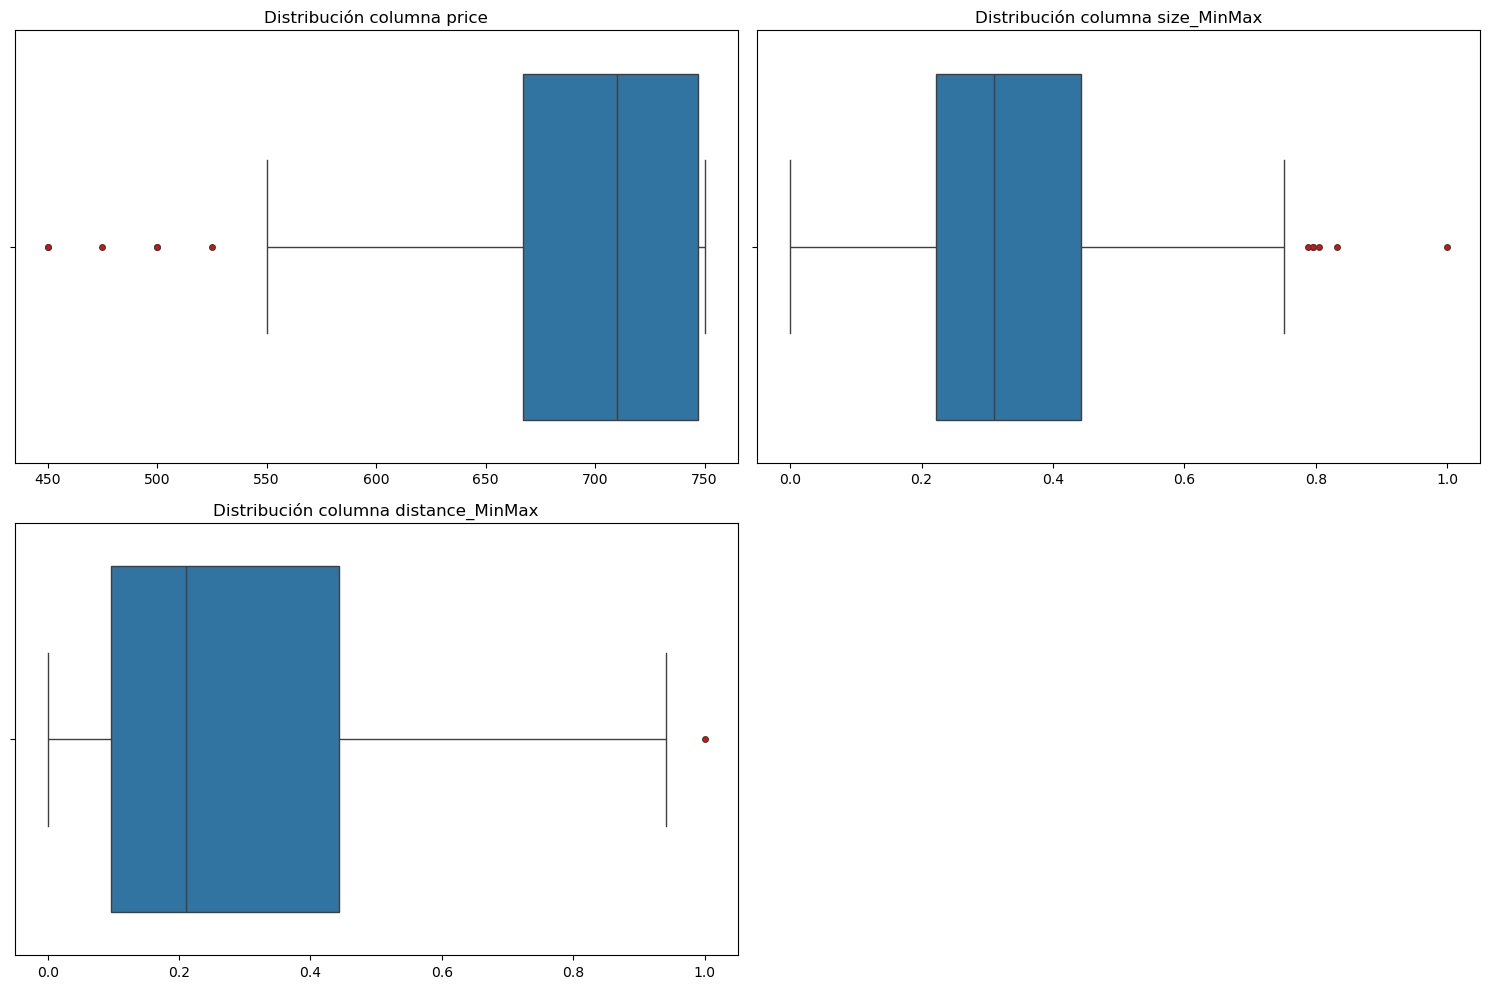

In [60]:
f.plot_outliers_univariados(df_filt, "b", (15,10))

In [61]:
df_est_con3=df_min[["price", "size_MinMax", "distance_MinMax"]]

In [62]:
(df_filt["size_MinMax"]> 0.8).sum()

3

In [63]:
(df_est_con3["size_MinMax"]> 0.8).sum()

3

In [64]:
(df_filt["price"]< 510).sum()

5

In [65]:
(df_est_con3["price"]< 510).sum()

6

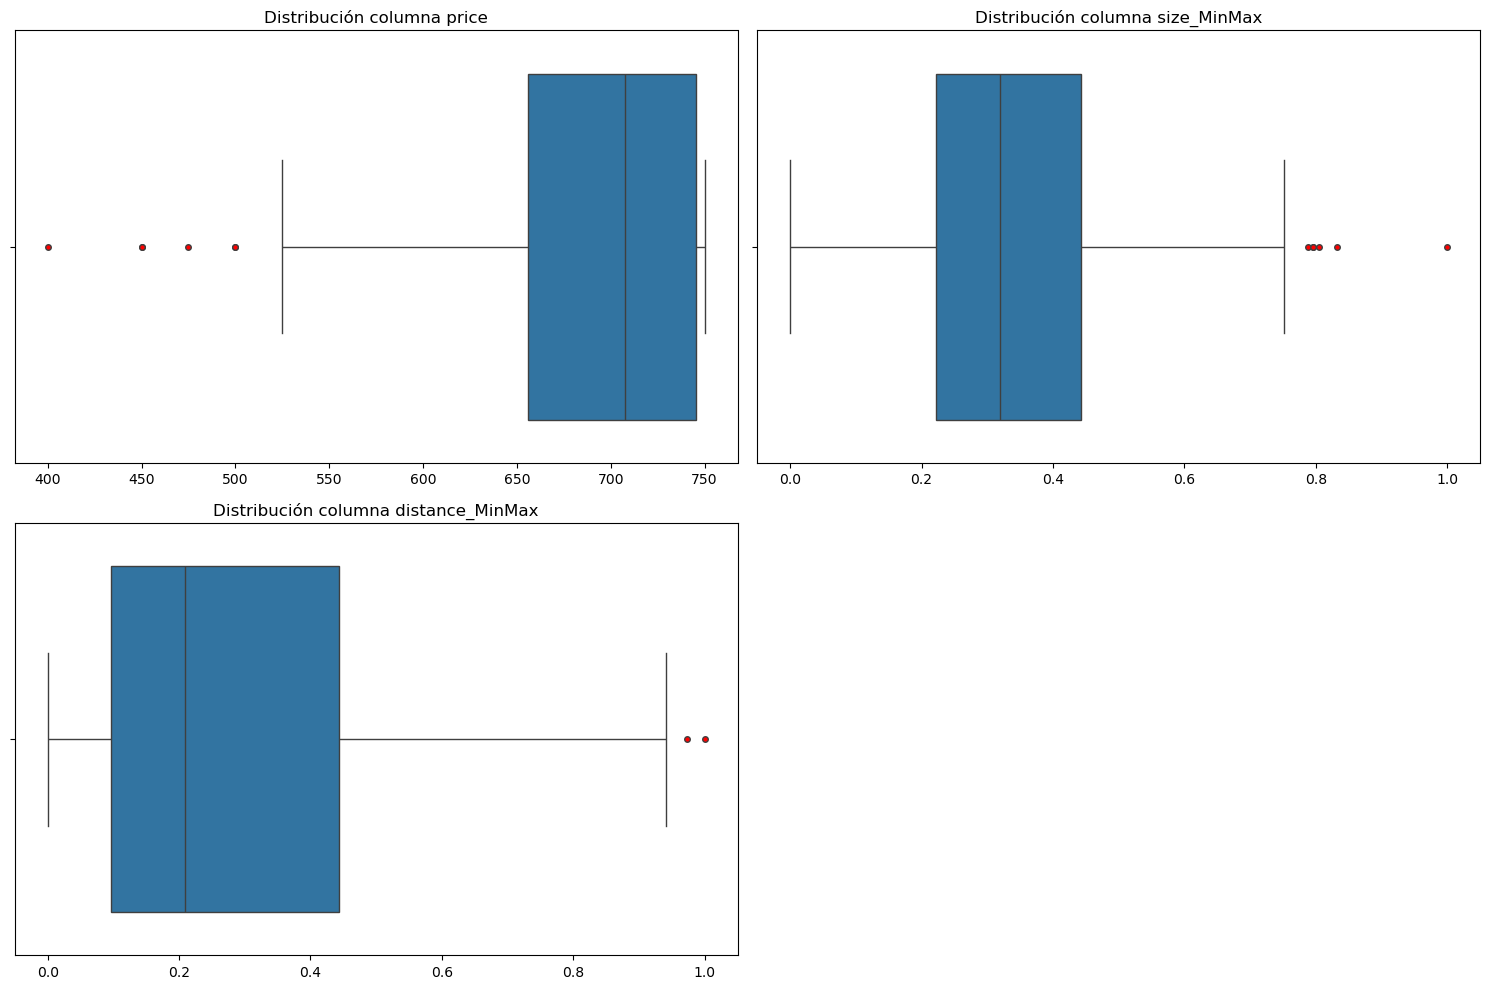

In [66]:
f.plot_outliers_univariados(df_est_con3, "b", (15,10))

caso con iterative

In [67]:
df_numericas=df_result.select_dtypes(include=np.number)
df_numericas.drop(columns="price", inplace=True)
imputer_iterative= IterativeImputer()       #Aquí se puede poner el KNNImputer o el RandomForestRegressor
                                            #missing values es por si los nulos no estan como np.nan sino en texto por ejemplo (aunque lo suyo es limpiarlo en el EDA)
                                            #initial_strategy= "median" sirve para indicar que me lo haga con las medianas
iterative_imputado=imputer_iterative.fit_transform(df_numericas)   #como es solo para numericas se tiene que meter el df de numericas pero hay que definirlo otra vez porque hemos dropeado duplicados
df_iterativo=df_result.copy()
df_num_sin_nulos=pd.DataFrame(iterative_imputado, columns= df_numericas.columns)  #para que tenga los mismo nombres de columnas
df_iterativo[df_numericas.columns]= df_num_sin_nulos    #Con esto metemos todo el dataframe de las numericas sin nulos donde corresponda rellenando esos nulos

In [68]:
df_iterativo.isna().sum()

price                     0
size_MinMax               0
rooms_MinMax              0
municipality_MinMax       0
distance_MinMax           0
                         ..
outliers_ifo_0.05_2000    0
outliers_ifo_0.1_100      0
outliers_ifo_0.1_400      0
outliers_ifo_0.1_1000     0
outliers_ifo_0.1_2000     0
Length: 114, dtype: int64

In [69]:
df_iterativo.columns

Index(['price', 'size_MinMax', 'rooms_MinMax', 'municipality_MinMax',
       'distance_MinMax', 'status_MinMax', 'floor_MinMax', 'hasLift_MinMax',
       'propertyType_chalet_MinMax', 'propertyType_countryHouse_MinMax',
       ...
       'outliers_ifo_0.01_1000', 'outliers_ifo_0.01_2000',
       'outliers_ifo_0.05_100', 'outliers_ifo_0.05_400',
       'outliers_ifo_0.05_1000', 'outliers_ifo_0.05_2000',
       'outliers_ifo_0.1_100', 'outliers_ifo_0.1_400', 'outliers_ifo_0.1_1000',
       'outliers_ifo_0.1_2000'],
      dtype='object', length=114)

Me quito las columnas de outliers ifo

In [70]:
lista_eliminar=['outliers_ifo_0.01_100',
       'outliers_ifo_0.01_400', 'outliers_ifo_0.01_1000',
       'outliers_ifo_0.01_2000', 'outliers_ifo_0.05_100',
       'outliers_ifo_0.05_400', 'outliers_ifo_0.05_1000',
       'outliers_ifo_0.05_2000', 'outliers_ifo_0.1_100',
       'outliers_ifo_0.1_400', 'outliers_ifo_0.1_1000',
       'outliers_ifo_0.1_2000']
df_iterativo.drop(columns= lista_eliminar, inplace=True)

In [71]:
df_iterativo.describe().T

,count,mean,std,min,25%,50%,75%,max
price,345.00,694.86,59.08,450.00,667.00,710.00,747.00,750.00
size_MinMax,345.00,0.34,0.17,0.00,0.22,0.31,0.44,1.00
rooms_MinMax,345.00,0.40,0.35,0.00,0.00,0.59,0.59,1.00
municipality_MinMax,345.00,0.87,0.17,0.19,0.81,0.92,1.00,1.00
distance_MinMax,345.00,0.28,0.23,0.00,0.10,0.20,0.44,1.00
...,...,...,...,...,...,...,...,...
district_Zona Estación_MinMax,345.00,0.01,0.08,0.00,0.00,0.00,0.00,1.00
district_Zona Estación- Centro_MinMax,345.00,0.00,0.05,0.00,0.00,0.00,0.00,1.00
district_Zona Industrial_MinMax,345.00,0.00,0.05,0.00,0.00,0.00,0.00,1.00
district_Zona Pueblo_MinMax,345.00,0.00,0.05,0.00,0.00,0.00,0.00,1.00


In [72]:
df_iterativo.to_csv("../../datos/datos4/datos_sin_outliers_iterativo.csv")

In [73]:
df_it=pd.read_csv("../../datos/datos4/datos_sin_outliers_iterativo.csv", index_col=0).reset_index(drop=True)

In [74]:
df_filt_it=df_it[["price", "size_MinMax", "distance_MinMax"]]

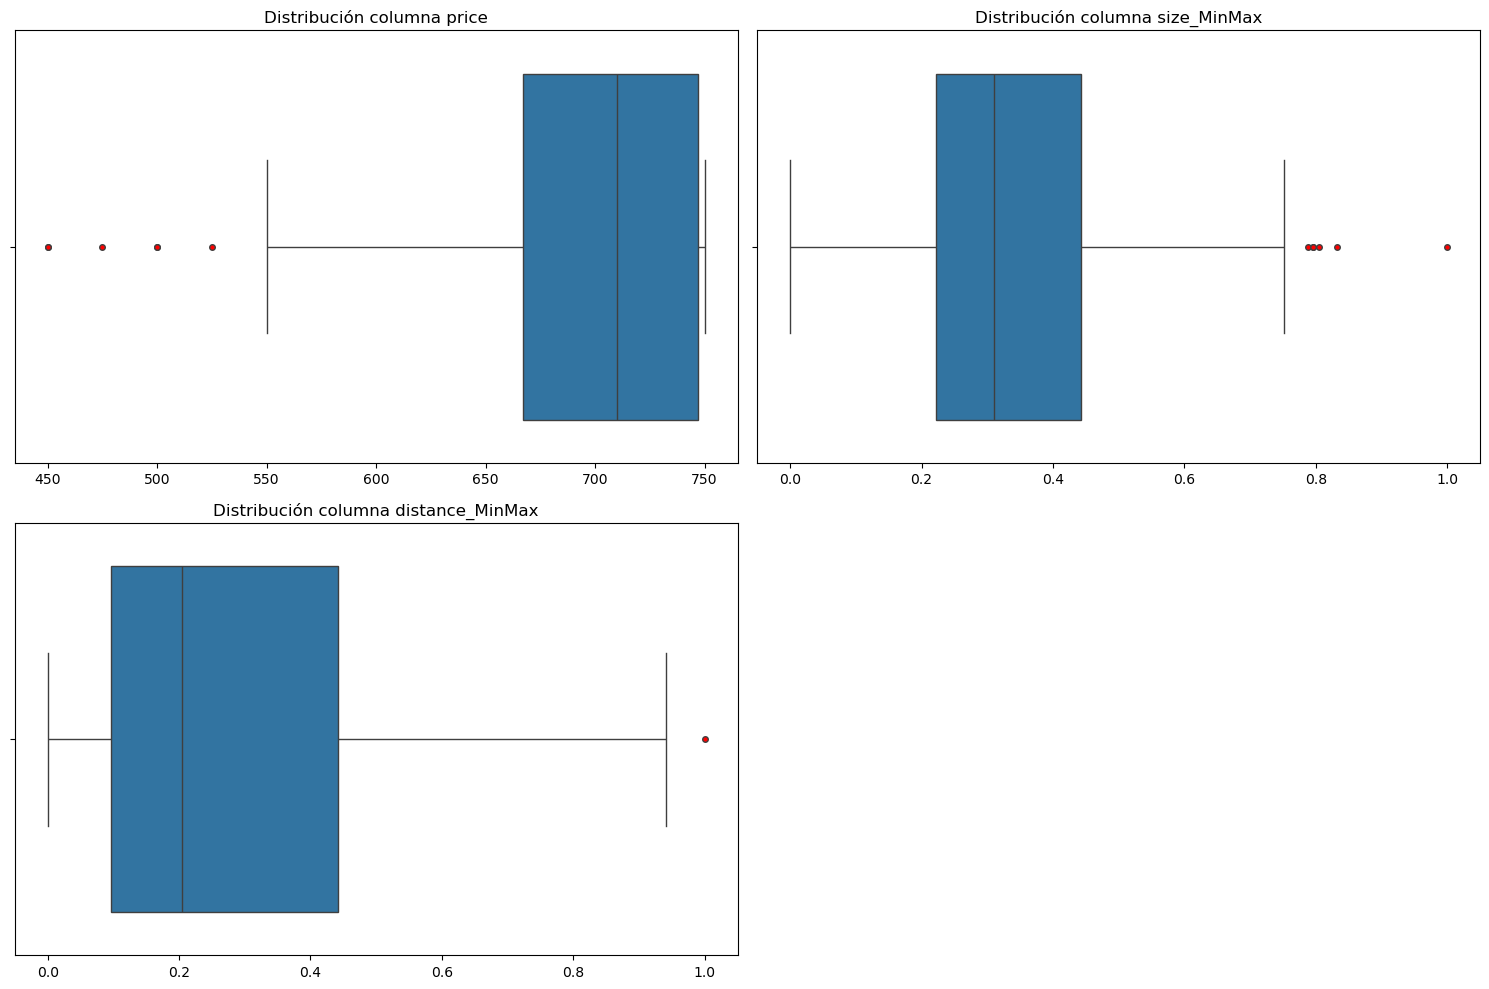

In [75]:
f.plot_outliers_univariados(df_filt_it, "b", (15,10))

In [76]:
df_est_con3=df_min[["price", "size_MinMax", "distance_MinMax"]]

In [77]:
(df_filt_it["size_MinMax"]> 0.8).sum()

3

In [78]:
(df_est_con3["size_MinMax"]> 0.8).sum()

3

In [79]:
(df_filt_it["price"]< 510).sum()

5

In [80]:
(df_est_con3["price"]< 510).sum()

6

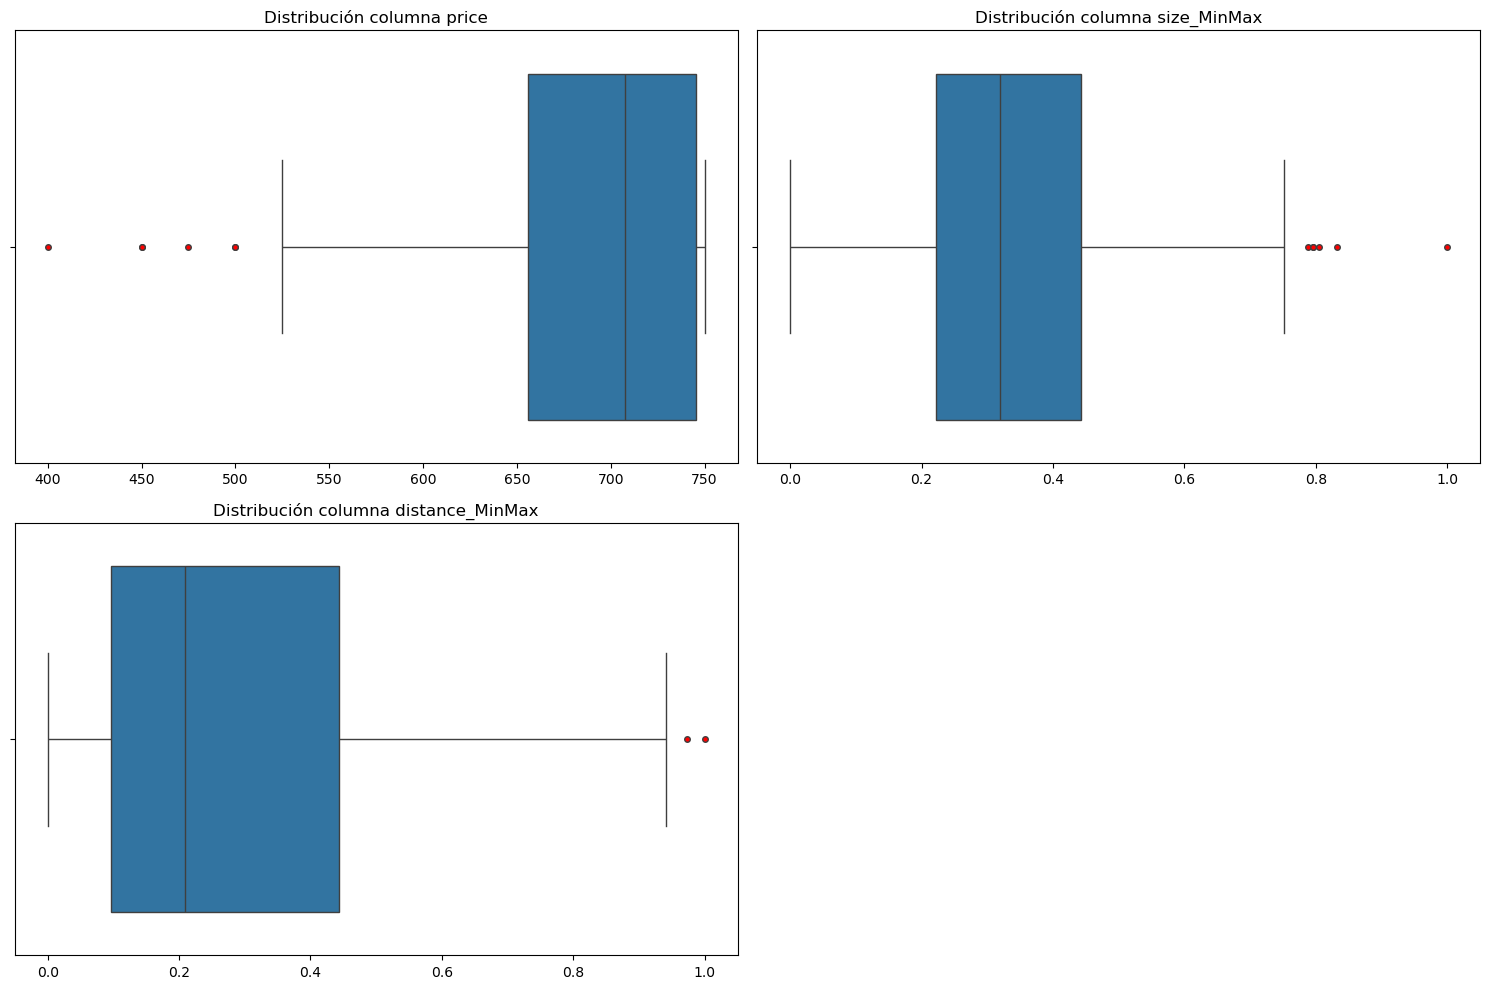

In [81]:
f.plot_outliers_univariados(df_est_con3, "b", (15,10))

Ya están tratados

Observamos que no hay diferencias muy significativas entre imputar con KNN o con ITERATIVE pero tras observar que el iterative reduce la dispersión entre la media y la mediana de size y que el KNN aumenta la desviación típica (variabilidad) en la distancia, nos decantamos finalmente por el uso del ITERATIVE